In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [122]:
symbol = 'S&P_500'
df = pd.read_csv(f'../datasets/{symbol}.csv')

df_target = df[['sma', 'macd', 'stochastic_k', 'stochastic_d', 'rsi', 'william_r']]
df_normalized = (df_target-df_target.min())/(df_target.max()-df_target.min())

In [286]:
features = []
labels = []
start_date = None
interval = 3
for i, row in df.iterrows():
    if i < 31: continue
    
    trading_signal_yesterday = df.trading_signal[i-4:i]
    sma = df_normalized.sma[i-interval:i+1]
    macd = df_normalized.macd[i-interval:i+1]
    stochastic_k = df_normalized.stochastic_k[i-interval:i+1]
    stochastic_d = df_normalized.stochastic_d[i-interval:i+1]
    rsi = df_normalized.rsi[i-interval:i+1]
    william_r = df_normalized.william_r[i-interval:i+1]
    
    features.append([trading_signal_yesterday, sma, macd, stochastic_k, stochastic_d, rsi, william_r])
    labels.append(df.trading_signal[i])
    
    if start_date is None:
        start_date = df.date[i]
    
features = np.array(features)
labels = np.array(labels)

In [287]:
features = np.reshape(features, (features.shape[0], 7, features.shape[2]))  
features.shape, labels

((12534, 7, 4),
 array([0.43689454, 0.5       , 0.5       , ..., 0.52838094, 0.69313551,
        0.52893504]))

In [288]:
y = labels
X = features
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

In [289]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["mae"])

In [290]:
history = model.fit(train_X, train_y, shuffle=True, batch_size=150, epochs=160, validation_data=(test_X, test_y))

Train on 9400 samples, validate on 3134 samples
Epoch 1/160
9400/9400 [==============================] - 10s 1ms/step - loss: 0.6411 - mean_absolute_error: 0.2347 - val_loss: 0.5673 - val_mean_absolute_error: 0.1860
Epoch 2/160
9400/9400 [==============================] - 3s 268us/step - loss: 0.5688 - mean_absolute_error: 0.1847 - val_loss: 0.5521 - val_mean_absolute_error: 0.1708
Epoch 3/160
9400/9400 [==============================] - 3s 280us/step - loss: 0.5633 - mean_absolute_error: 0.1779 - val_loss: 0.5507 - val_mean_absolute_error: 0.1684
Epoch 4/160
9400/9400 [==============================] - 3s 268us/step - loss: 0.5589 - mean_absolute_error: 0.1752 - val_loss: 0.5481 - val_mean_absolute_error: 0.1677
Epoch 5/160
9400/9400 [==============================] - 3s 276us/step - loss: 0.5579 - mean_absolute_error: 0.1746 - val_loss: 0.5530 - val_mean_absolute_error: 0.1698
Epoch 6/160
9400/9400 [==============================] - 3s 281us/step - loss: 0.5575 - mean_absolute_error:

In [291]:
prediction = model.predict(test_X)

score = model.evaluate(test_X, test_y)
print(score)

predictions = model.predict(test_X)
print(f"MAE: {mean_absolute_error(test_y, predictions)}")

3134/3134 [==============================] - 1s 260us/step
[0.4995022701966055, 0.12266704130111869]
MAE: 0.12266704090184062


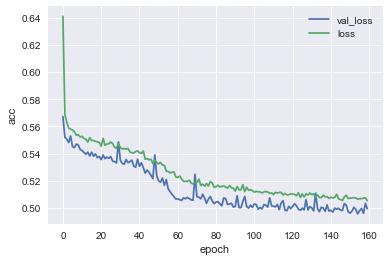

In [292]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [293]:
padding_look_back = df[df.date == start_date].index.values[0]  
padding = np.full(train_X.shape[0] + padding_look_back, np.nan)
prediction_trading_signal = np.concatenate((padding, predictions), axis=None)
df['p_t_s_lstm'] = prediction_trading_signal
df.to_csv(f'../datasets/{symbol}.csv')